# InSAR Time Series Analysis using MintPy and ARIA products
## Mapping Subsidence in the California Central Valley with InSAR time series

**Authors:** Eric Fielding, David Bekaert, Heresh Fattahi and Zhang Yunjun 

 This notebook is a modification by Eric Fielding from the notebook 
 (https://opensciencelab.asf.alaska.edu/lab/opensarlab/hub/user-redirect/lab/tree/notebooks/SAR_Training/English/Hazards/LosAngeles_time_series.ipynb)
 
That Los Angeles time series note was a second modification of the 
 (https://opensciencelab.asf.alaska.edu/lab/opensarlab/hub/user-redirect/lab/tree/NISAR_ST_demo/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/smallbaselineApp_aria.ipynb)
 by David Bekaert, Heresh Fattahi and Zhang Yunjun that was originally focused on San Francisco. 

 This notebook is a modification from the [original](https://nbviewer.jupyter.org/github/insarlab/MintPy-tutorial/blob/master/smallbaselineApp_aria.ipynb) by Heresh Fattahi and Zhang Yunjun. 

Additional Python code from the NISAR Solid Earth Level 2 science Secular Deformation requirement validation notebook has been added from the **Notebooks for NISAR Solid Earth Algorithm Theoretical Basis Documents**. See https://github.com/nisar-solid/ATBD for the full set of notebooks and explanation. We use an example dataset that was prepared for the NISAR validation.

**ARIA S1 GUNW**

The Caltech-JPL ARIA project in partnership with NASA Getting Ready for NISAR (GRFN) project has been generated surface displacement products (interferograms) mimicking the NISAR L2 GUNW (Geocoded Unwrapped phase interferograms) product formatting. The interferograms are stored at the NASA ASF DAAC, and are accessible with an Open Source set of tools called ARIA-tools. The Miami Insar Timeseries software in PYthon (MintPy), an open-source package for InSAR time-series analysis, is compatible with the outputs from the ARIA-tools package, and in combination with the ARIA-tools pre-processor can be used to estimate ground displacement time-series. 

The Jupyter notebook presented here is meant as an practical example on the use of Jupyter for exploring landslide displacements. In the example below, we will demonstrate a time-series derived from ARIA standard InSAR products over the southern Central Valley of California, also called the San Joaquin Valley revealing rapid subsidence due to large amounts of groundwater withdrawal. 

See the other tutorials on ARIA-tools to learn more about how to use that package.

<div class="alert alert-warning">
<b>To save time, we have pre-ran the ARIA-tools pacakge and data loading into MintPy</b> 

!ariaDownload.py -b '36.18 36.26 -119.91 -119.77' --track 144 -s 20180101 -e 20190101
    
!!ariaTSsetup.py -f 'products/*.nc' -b '35.77 36.75 -120.61 -118.06'  --mask Download
    
!smallbaselineApp.py -t Central_Valley.cfg --dostep load_data
    

</div>


<div class="alert alert-warning">
 
<b>The staged data was uploaded in S3 data bucket of openSARlab and can be downloaded using:</b>
    
!aws s3 cp ss3://asf-jupyter-data-west/NISAR_SE/CentralValleyA144.zip CentralValleyA144.zip

This data should be available from openSARlabs or other computer systems as long as the AWS command line tools are installed to download from S3.
</div>

# 0. Notebook setup

The cell below is required to be ran each time the notebook is started and ensures correct set-up of the notebook.

In [1]:
import os
import glob
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import subprocess

# define the work Top directory
worktop_dir = os.path.abspath(os.getcwd())
print("Top directory: ", worktop_dir)
if not os.path.isdir(worktop_dir):
    os.makedirs(worktop_dir)
    print('Create directory: {}'.format(worktop_dir))
print('Go to work directory: {}'.format(worktop_dir))
os.chdir(worktop_dir)  
    
plt.rcParams.update({'font.size': 12})

# utils function to create the MintPy analysis configuration file
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process ARIA sample products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

 
# verify if mintpy install is version 1.3.2 and older:
try:
    from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix
except:
    print("Looks like mintPy 1.3.x is not installed")
    
# verify if mintpy install is version 1.5 and newer:
try:
    from mintpy.utils import readfile, utils as ut, plot as pp
    from mintpy.cli import view, tsview, plot_network, plot_transection
    from mintpy.view import prep_slice, plot_slice
except:
    print("Looks like mintPy 1.5.x is not completely installed")


Top directory:  /home/jovyan/CentralValley
Go to work directory: /home/jovyan/CentralValley


To save time for this demonstration, we will use a staged (pre-processed and saved online) dataset from the NISAR Solid Earth Science Team covering an area of the Central Valley

In [2]:
# Choose a site and track direction
# Available NISAR Solid Earth secular displacement validation sites are: 
# ['RidgecrestA64','MojaveD173','MojaveD173_3year','CentralValleyA144']
# We use the CentralValleyA144 site in the Central Valley for this demonstration

site='CentralValleyA144'  

In [3]:
################# Set Directories ##########################################
print('\nCurrent directory:',os.getcwd())

if 'work_dir' not in locals():
    work_dir = Path.cwd()/'work'/site

print("Work directory:", work_dir)
work_dir.mkdir(parents=True, exist_ok=True)
# Change to Workdir
os.chdir(work_dir)

gunw_dir = work_dir/'products'
gunw_dir.mkdir(parents=True, exist_ok=True)
print("   GUNW    dir:", gunw_dir) 

mintpy_dir = work_dir/'MintPy' 
mintpy_dir.mkdir(parents=True, exist_ok=True)
print("   MintPy  dir:", mintpy_dir)
### Change to MintPy workdir
os.chdir(mintpy_dir)
vel_file = os.path.join(mintpy_dir, 'velocity.h5')
msk_file = os.path.join(mintpy_dir, 'maskConnComp.h5')  # maskTempCoh.h5 maskConnComp.h5
############################################################################
### List of CalVal Sites:
'''
Set NISAR calval sites:
    CentralValleyA144  : Central Valley track 144
    OklahomaA107       : Oklahoma
    PuertoRicoD98      : Puerto Rico (Earthquake M6.4 on 20200107) - Descending track 
    PuertoRicoA135     : Puerto Rico (Earthquake M6.4 on 20200107 & large aftershock on 20200703) - Ascending track
    RidgecrestD71      : Ridgecrest  (Earthquake M7.2 on 20190705) - Descending track
    RidgecrestA64      : Ridgecrest  (Earthquake M7.2 on 20190705) - Ascending track
    MojaveD173         : Mojave desert (Ridgecrest Earthquake M7.2 on 20190705) - Descending track
    MojaveD173_3year   : Mojave desert (Ridgecrest Earthquake M7.2 on 20190705) - Descending track

ARIA & MintPy parameters:
    calval_location : name
    download_region : download box in S,N,W,E format
    analysis_region : analysis box in S,N,W,E format (must be within download_region)
    reference_lalo : latitute,longitude in geographic coordinates (default: auto)
    download_start_date : download start date as YYYMMDD  
    download_end_date   : download end date as YYYMMDD
    earthquakeDate :  arbitrary date for testing with the central_valley dataset
    sentinel_track : sentinel track to download
    gps_ref_site_name : Name of the GPS site for InSAR re-referencing
    tempBaseMax' : maximum number of days, 'don't use interferograms longer than this value 
    ifgExcludeList : default is not to exclude any interferograms
    maskWater' :  interior locations don't need to mask water
'''
sites = {
    ##########  CENTRAL VALLEY ##############
    'CentralValleyA144' : {'calval_location' : 'Central_Valley',
            'download_region' : '"36.18 36.26 -119.91 -119.77"', # download box in S,N,W,E format
            'analysis_region' : '"35.77 36.75 -120.61 -118.06"', # analysis box in S,N,W,E format (must be within download_region)
            'reference_lalo' : 'auto',
            'download_start_date' : '20180101',
            'download_end_date' : '20190101',
            'earthquakeDate' : '20180412',                       # arbitrary date for testing with the central_valley dataset
            'sentinel_track' : '144',
            'gps_ref_site_name' : 'CAWO',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},                       # reference site for this area
    ##########  OKLAHOMA ##############
    'OklahomaA107' : {'calval_location' : 'Oklahoma',
            'download_region' : '"31.7 37.4 -103.3 -93.5"',      # download box in S,N,W,E format
            'analysis_region' : '"35.25 36.5 -100.5 -98.5"',     # analysis box in S,N,W,E format (must be within download_region)
            'reference_lalo' : 'auto',
            'download_start_date' : '20210101',
            'download_end_date' : '20210801',
            'earthquakeDate' : '20210328',                       # arbitrary date for testing with the Oklahoma dataset
            'sentinel_track' : '107',
            'gps_ref_site_name' : 'OKCL',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},
    ##########  PUERTO RICO ##############
    'PuertoRicoD98' : {'calval_location' : 'PuertoRicoDesc',
            'download_region' : '"17.5 18.9 -67.5 -66.0"',       # download box in S,N,W,E format
            'analysis_region' : '"17.9 18.5 -67.3 -66.2"',       # analysis box in S,N,W,E format (must be within download_region)
            'reference_lalo' : 'auto',
            'download_start_date' : '20190701',
            'download_end_date' : '20200930',
            'earthquakeDate' : '20200107',                       # date of M6.4 quake
            'sentinel_track' : '98',                             # descending track
            'gps_ref_site_name' : 'PRLT',
            'tempBaseMax' : 24,                                  # don't use interferograms longer than 24 days
            'ifgExcludeList' : 'auto', 
            'maskWater' : True},                                 # need to mask ocean around Puerto Rico island
    'PuertoRicoA135' : {'calval_location' : 'PuertoRicoAsc',
             'download_region' : '"17.5 18.9 -67.5 -66.0"',      # download box in S,N,W,E format
             'analysis_region' : '"17.9 18.5 -67.3 -66.2"',      # analysis box in S,N,W,E format (must be within download_region)
             'reference_lalo' : 'auto',
             'download_start_date' : '20190701',
             'download_end_date' : '20200930',
             'earthquakeDate' : '20200107',                      # date of M6.4 quake
             'earthquakeDate2' : '20200703',                     # date of large aftershock
             'sentinel_track' : '135',                           # ascending track
             'gps_ref_site_name' : 'PRLT',
             'tempBaseMax' : 24,                                 # don't use interferograms longer than 24 days
             'ifgExcludeList' : 'auto',
             'maskWater' : True},                                # need to mask ocean around Puerto Rico island
    ##########  RIDGECREST ##############
    'RidgecrestD71': {'calval_location' : 'RidgecrestD71',
                      'download_region' : '"34.5 37.5 -119.0 -116.0"', # download box in S,N,W,E format
                      'analysis_region' : '"34.7 37.2 -118.9 -116.1"', # analysis box in S,N,W,E format (must be within download_region)
                      'reference_lalo' : 'auto',
                      'download_start_date' : '20190601',
                      'download_end_date' : '20190831',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '71',
                      'gps_ref_site_name' : 'ISLK',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'auto',
                      'maskWater' : False},
    'RidgecrestA64': {'calval_location' : 'RidgecrestA64',
                      'download_region' : '"34.5 37.5 -119.0 -116.0"', # download box in S,N,W,E format
                      'analysis_region' : '"34.7 37.2 -118.9 -116.1"', # analysis box in S,N,W,E format (must be within download_region)
                      'reference_lalo' : 'auto',
                      'download_start_date' : '20190101',
                      'download_end_date' : '20190701',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '64',
                      'gps_ref_site_name' : 'ISLK',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'none',   # list of bad ifgs to exclude from time-series analysis
                      'maskWater' : False},
    ##########  MOJAVE ##############
    'MojaveD173': {'calval_location' : 'MojaveD173',
                      'download_region' : '"34.5 35.6 -116.62 -114.39"', # download box in S,N,W,E format
                      'analysis_region' : '"34.66 35.60 -116.62 -114.39"', # analysis box in S,N,W,E format (must be within download_region)
                      'reference_lalo' : '35.20495,-115.81229',
                      'download_start_date' : '20180101',
                      'download_end_date' : '20181231',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '173',
                      'gps_ref_site_name' : 'P619',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'auto',
                      'maskWater' : False},
    'MojaveD173_3year': {'calval_location' : 'MojaveD173_3year',
                      'download_region' : '"34.5 35.6 -116.62 -114.39"', # download box in S,N,W,E format
                      'analysis_region' : '"34.66 35.60 -116.62 -114.39"', # analysis box in S,N,W,E format (must be within download_region)
                      'reference_lalo' : '35.20495,-115.81229',
                      'download_start_date' : '20160101',
                      'download_end_date' : '20181231',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '173',
                      'gps_ref_site_name' : 'P619',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'auto',
                      'maskWater' : False}
}

# only the following four sites have the pre-processed data staged with a zip file
secular_available_sites = ['RidgecrestA64','MojaveD173','MojaveD173_3year','CentralValleyA144']

# the following checks whether the site is available. 
# You can comment out this check if you want to run another site and do your own ARIA-tools download
if site not in secular_available_sites:
    msg = '\nSelected site not available! Please select one of the following sites:: \n{}'.format(secular_available_sites)
    raise Exception(msg)
else:
    print('\nSelected site: {}'.format(site))
    for key, value in sites[site].items():
        print('   '+ key, ' : ', value)


Current directory: /home/jovyan/CentralValley
Work directory: /home/jovyan/CentralValley/work/CentralValleyA144
   GUNW    dir: /home/jovyan/CentralValley/work/CentralValleyA144/products
   MintPy  dir: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy

Selected site: CentralValleyA144
   calval_location  :  Central_Valley
   download_region  :  "36.18 36.26 -119.91 -119.77"
   analysis_region  :  "35.77 36.75 -120.61 -118.06"
   reference_lalo  :  auto
   download_start_date  :  20180101
   download_end_date  :  20190101
   earthquakeDate  :  20180412
   sentinel_track  :  144
   gps_ref_site_name  :  CAWO
   tempBaseMax  :  auto
   ifgExcludeList  :  auto
   maskWater  :  False


In [4]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = True
     
######### DO NOT CHANGE LINES BELOW ########

if Use_Staged_Data:
     # Check if a stage file from S3 already exist, if not try and download it
    if len(glob.glob('MintPy/inputs/*.h5')) == 0:
        os.chdir(work_dir.parents[0])
        zip_name = site + '.zip'
        print('Downloading:',  Path.cwd()/zip_name)
        if not os.path.isfile(zip_name):
            try:
                command = "aws s3 cp --no-sign-request s3://asf-jupyter-data-west/NISAR_SE/" + site + '.zip ' + zip_name
                subprocess.run(command, shell=True, check = True)
            except:
                command = 'wget --no-check-certificate --no-proxy "http://asf-jupyter-data-west.s3.amazonaws.com/NISAR_SE/' + site + '.zip" -q --show-progress'
                print('\nDownloading staged data ... ')
                subprocess.run(command, stdout=None, stderr=subprocess.PIPE, shell=True)
            finally:
                if (work_dir.parents[0]/zip_name).is_file():
                    print('Finished downloading!')
                else:
                    raise RuntimeError('Failed downloading Staged data!!! Install aws or wget to proceed')

        command = 'unzip ' + str(work_dir.parents[0]/zip_name) +'; rm ' + str(work_dir.parents[0]/zip_name)
        process = subprocess.run(command, shell=True)
    if not os.path.exists(work_dir):
        raise Exception("Staged data for site {} not sucessfully generated. Please delete site-name folder {} and rerun this cell".format(site, work_dir))
    print('Finish preparing staged data for MintPy!!')

else:
    ##################### 1. Download (Aria) Interferograms from ASF ################
    os.chdir(work_dir)
    print('NEEDED To Download ARIA GUNWs: \n Link to create account : https://urs.earthdata.nasa.gov/')
    earthdata_user = input('Please type your Earthdata username:')
    earthdata_password = input('Please type your Earthdata password:')
    print('NEEDED To Download DEMs: \n Link to create account : https://portal.opentopography.org/login')
    if os.path.exists('~/.topoapi'): # if OpenTopo API key already installed
        print('OpenTopo API key appears to be installed, using that')
    else:
        print('API key location: My Account > myOpenTopo Authorizations and API Key > Request API key')
        opentopography_api_key = input('Please type your OpenTopo API key:')

    ######################## USE ARIA-TOOLS TO DOWNLOAD GUNW ########################
    '''
    REFERENCE: https://github.com/aria-tools/ARIA-tools
    '''
    aria_download = '''ariaDownload.py -b {bbox} -u {user} -p {password} -s {start}  -e {end} -t {track} -o Count'''

    ###############################################################################
    print('CalVal site {}'.format(site))
    print('  Searching for available GUNW products:\n')

    command = aria_download.format(bbox = sites[site]['download_region'],
                                   start = sites[site]['download_start_date'],
                                   end = sites[site]['download_end_date'],
                                   track = sites[site]['sentinel_track'],
                                   user = earthdata_user,
                                   password = earthdata_password)
      
    process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text = True, shell = True)
    print(process.stdout)

    ############## Download GUNW ##################
    print("Start downloading GUNW files ...")
    process = subprocess.run(command.split(' -o')[0], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)
    # Missing progressbar
    print("Downloaded {} GUNW files in: {}\n".format(len([(x) for x in os.listdir(gunw_dir) if x.endswith('.nc')]), gunw_dir))

    ############## DO little CLEANING ###########
    data_to_clean = ["avg_rates.csv", "ASFDataDload0.py", "AvgDlSpeed.png", "error.log"]

    for i, file in enumerate(data_to_clean):
        print('Cleaning unnecessary data {} in {}'.format(file, gunw_dir))
        (gunw_dir/file).unlink(missing_ok=True)

    #Delete error log file from workdir
    print('Cleaning unnecessary data error.log in {}'.format(work_dir))
    (work_dir/"error.log").unlink(missing_ok=True)


Downloading: /home/jovyan/CentralValley/work/CentralValleyA144.zip
download: s3://asf-jupyter-data-west/NISAR_SE/CentralValleyA144.zip to ./CentralValleyA144.zip
Finished downloading!
Archive:  /home/jovyan/CentralValley/work/CentralValleyA144.zip
  inflating: CentralValleyA144/MintPy/coherenceHistory.pdf  
  inflating: CentralValleyA144/MintPy/vel_insar_vs_gnss.png  
  inflating: CentralValleyA144/MintPy/coherenceMatrix.pdf  
  inflating: CentralValleyA144/MintPy/network.pdf  
  inflating: CentralValleyA144/MintPy/pbaseHistory.pdf  


replace CentralValleyA144/MintPy/Central_Valley.cfg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


Finish preparing staged data for MintPy!!


The following command will download all the ARIA standard products over part of the California Central Valley for the year 2018, which is 90 products. This will take some time to complete if the data is not already downloaded.

In [5]:
# download data for descending track 144 over part of San Joaquin Valley in southern Central Valley
#!ariaDownload.py -b '36.18 36.26 -119.91 -119.77' --track 144 -s 20180101 -e 20190101

This ARIA time-series setup would cover the whole Sentinel-1 scene and would take a while to process, so we are skipping this setup.

In [6]:
#!ariaTSsetup.py -f 'products/*.nc' -b '36.18 36.26 -119.91 -119.77' --mask Download

The following ARIA time-series setup `ariaTSsetup.py` extracts the data that covers only a small area around the city of Corcoran in the San Joaquin Valley where the most rapid subsidence occurred in 2018 to speed the time-series processing, which we specify with the bounding box. We also download the water mask to avoid using data over the ocean.

In [7]:
#!ariaTSsetup.py -f 'products/*.nc' -b '35.77 36.75 -120.61 -118.06'  --mask Download

# 1. smallbaselineApp.py overview

This application provides a workflow which includes several steps to invert a stack of unwrapped interferograms and apply different corrections to obtain ground displacement timeseries.  
The workflow consists of two main blocks:

* correcting unwrapping errors and inverting for the raw phase time-series (blue ovals),
* correcting for noise from different sources to obtain the displacement time-series (green ovals).

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg). In this notebook, we will walk through some of these steps, for a complete example see the [MintPy repository](https://github.com/insarlab/MintPy).

<p align="left">
  <img width="600" src="docs/smallbaselineApp_workflow.png">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

## 1.1 Processing steps of smallbaselineApp.py

The MintPy **smallbaselineApp.py** application provides a workflow to invert a stack of unwrapped interferograms and apply different (often optional) corrections to obtain ground displacement timeseries. A detailed overview of the options can be retrieved by involking the help option:

In [8]:
!smallbaselineApp.py --help

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --plot                plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  
  

## 1.2 Configuring processing parameters

The processing parameters for the **smallbaselineApp.py** are controlled through a configuration file. If no file is provided the default [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg) configuration is used. Here we use the configuration parameters generated below (or included with the staged data), which already contains selected, manually modified configuration parameters for this time-series analysis.

In [9]:
config_file = Path(mintpy_dir)/(sites[site]['calval_location'] + '.cfg')

if not Use_Staged_Data:
    ####################################################################
    ### Write smallbaseline.py config file
    config_file_content = """
    mintpy.load.processor = aria
    mintpy.compute.numWorker = auto
    mintpy.load.unwFile = ../stack/unwrapStack.vrt
    mintpy.load.corFile = ../stack/cohStack.vrt
    mintpy.load.connCompFile = ../stack/connCompStack.vrt
    mintpy.load.demFile = ../DEM/SRTM_3arcsec.dem
    mintpy.load.incAngleFile = ../incidenceAngle/*.vrt
    mintpy.load.azAngleFile = ../azimuthAngle/*.vrt
    mintpy.load.waterMaskFile = {mask_file}
    mintpy.topographicResidual.pixelwiseGeometry = no
    mintpy.troposphericDelay.method = no
    mintpy.topographicResidual = no
    mintpy.network.tempBaseMax = {tempmax}
    mintpy.network.startDate = {startdatenet}
    mintpy.network.endDate = {enddatenet}
    mintpy.velocity.startDate = {startdatevel}
    mintpy.velocity.endDate = {enddatevel}
    mintpy.reference.lalo = {reference_lalo}
    mintpy.network.excludeIfgIndex = {excludeIfg}""".format(mask_file = mask_file,
                                                            tempmax=sites[site]['tempBaseMax'],
                                                            excludeIfg=sites[site]['ifgExcludeList'],
                                                            startdatenet=sites[site]['download_start_date'],
                                                            enddatenet=sites[site]['download_end_date'],
                                                            startdatevel=sites[site]['download_start_date'],
                                                            enddatevel=sites[site]['download_end_date'],
                                                            reference_lalo=sites[site]['reference_lalo'])

    config_file.write_text(config_file_content)

print('MintPy config file:\n    {}:'.format(config_file))
print(config_file.read_text())

MintPy config file:
    /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/Central_Valley.cfg:
mintpy.load.processor = aria
mintpy.compute.numWorker = auto 
mintpy.load.unwFile = ../stack/unwrapStack.vrt
mintpy.load.corFile = ../stack/cohStack.vrt
mintpy.load.connCompFile = ../stack/connCompStack.vrt
mintpy.load.demFile = ../DEM/SRTM_3arcsec.dem
mintpy.load.incAngleFile = ../incidenceAngle/*.vrt
mintpy.load.azAngleFile = ../azimuthAngle/*.vrt
mintpy.load.waterMaskFile = ../mask/watermask.msk
mintpy.reference.lalo = auto
mintpy.topographicResidual.pixelwiseGeometry = no
mintpy.troposphericDelay.method = no
mintpy.topographicResidual = no
mintpy.network.tempBaseMax = auto
mintpy.network.excludeIfgIndex = auto



# 2. Small Baseline Time Series Analysis

## 2.1. Loading ARIA data into MintPy

The [ARIA-tools package](https://github.com/aria-tools/ARIA-tools) is used as a pre-processor for MintPY. It has a download tool that wraps around the ASF DAAC API, and includes tools for stitching/cropping and time-series preparation. The output of the time-series preparation is compatible with the [data directory](https://mintpy.readthedocs.io/en/latest/dir_structure/) structure from MintPy. To save time, we have already pre-ran these steps. The commands used were:

```
!ariaDownload.py -b '36.18 36.26 -119.91 -119.77' --track 144 -s 20180101 -e 20190101
#!ariaTSsetup.py -f 'products/*.nc' -b '35.77 36.75 -120.61 -118.06'  --mask Download
```

The `ariaTSsetup.py` step above (or the pre-processed `CentralValleyA144.zip`) extracted the data for the subset we specified and found a total of 86 products that cover our study area. Now we load the data for the subset area into MintPy.

The next step loads the data.

In [10]:

print('Go to work directory: {}'.format(mintpy_dir))
os.chdir(mintpy_dir)  

command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep load_data'
process = subprocess.run(command, shell=True)
print('Mintpy input files:')
[x for x in os.listdir('inputs') if x.endswith('.h5')]

Go to work directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy


/home/jovyan/.local/envs/osl_mintpy/lib/python3.9/site-packages/mintpy/load_data.py:735: UserWarning: prep_aria.py failed. Assuming its result exists and continue...
  warnings.warn('prep_aria.py failed. Assuming its result exists and continue...')


MintPy version 1.5.1, date 2023-01-03
--RUN-at-2023-10-31 20:26:54.247464--
Current directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Central_Valley
Go to work directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
read custom template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/Central_Valley.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/CentralValley/w

['geometryGeo.h5', 'ifgramStack.h5']

The output of the loading step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata.  
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.). 

In [11]:
!ls inputs

Central_Valley.cfg  geometryGeo.h5  ifgramStack.h5  smallbaselineApp.cfg


<div class="alert alert-info">
<b>info.py :</b> 
To get general infomation about a MintPy product, run info.py on the file.   
</div>

In [12]:
!info.py inputs/ifgramStack.h5

******************** Basic File Info ************************
file name: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                          7
  ANTENNA_SIDE                                    -1
  CENTER_LINE_UTC                                 50402.0
  EARTH_RADIUS                                    6337286.638938101
  FILE_LENGTH                                     1177
  FILE_TYPE                                       ifgramStack
  HEADING                                         -168
  HEIGHT                                          693000.0
  LAT_REF1                                        36.75124999999996
  LAT_REF2                                        36.75124999999996
  LAT_REF3                                        35.77041666666667
  LAT_REF4                                        35.77

In [13]:
!info.py inputs/geometryGeo.h5

******************** Basic File Info ************************
file name: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/inputs/geometryGeo.h5
file type: geometry
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                          7
  ANTENNA_SIDE                                    -1
  CENTER_LINE_UTC                                 50402.0
  EARTH_RADIUS                                    6337286.638938101
  FILE_LENGTH                                     1177
  FILE_TYPE                                       geometry
  HEADING                                         -168
  HEIGHT                                          693000.0
  LAT_REF1                                        36.75124999999996
  LAT_REF2                                        36.75124999999996
  LAT_REF3                                        35.77041666666667
  LAT_REF4                                        35.77041666

## 2.2. Plotting the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- ifgramStack_coherence_spatialAvg.txt: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- Network.pdf: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. 
- CoherenceMatrix.pdf shows the avergae coherence pairs between all available pairs in the stack.

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2023-10-31 20:28:01.090213--
Current directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Central_Valley
Go to work directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
read custom template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/Central_Valley.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/CentralValley/work/CentralVa

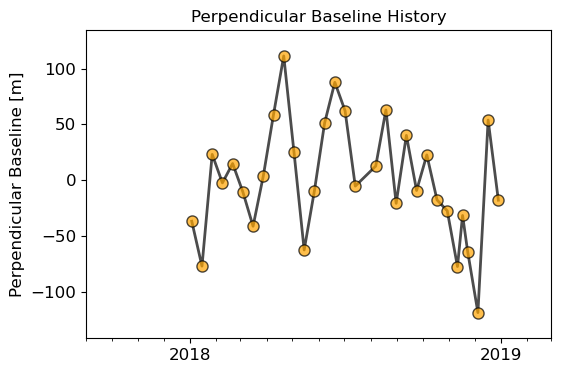

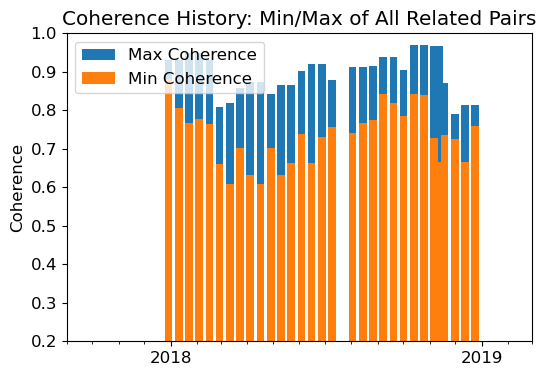

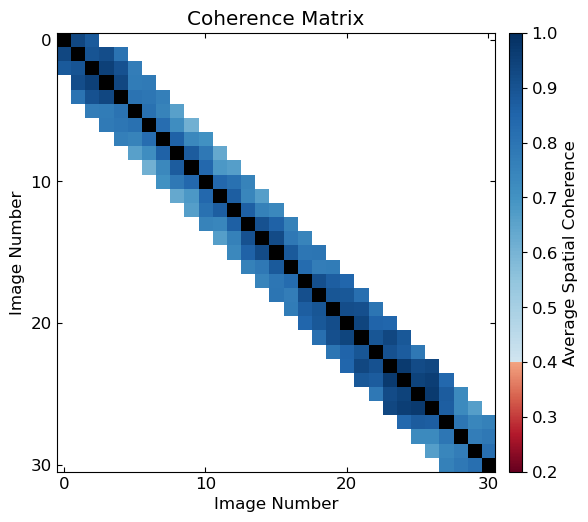

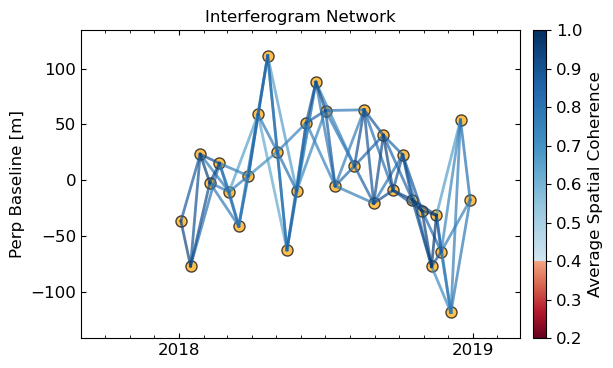

In [14]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep modify_network'
process = subprocess.run(command, shell=True)
#!smallbaselineApp.py Central_Valley.cfg  --dostep modify_network
plot_network.main(['inputs/ifgramStack.h5'])


## 2.3.  Mask generation

Mask files can be can be used to mask pixels in the time-series processing. Below we generate a mask file based on the connected components, which is a metric for unwrapping quality.

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 already exists.
2) output file is newer than input dataset: connectComponent.
run or skip: skip.
run view.py in MintPy version 1.5.1, date 2023-01-03
input file is mask file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/maskConnComp.h5 in bool format
file size in y/x: (1177, 3061)
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 3061, 1177)
subset coverage in y/x: (0, 0, 3061, 1177)
data   coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
subset coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
------------------------------------------------------------------------
colormap: jet
figure title: maskConnComp
figure size : [10.00, 3.08]
reading data ...
data has uniform and limited number (2 <= 

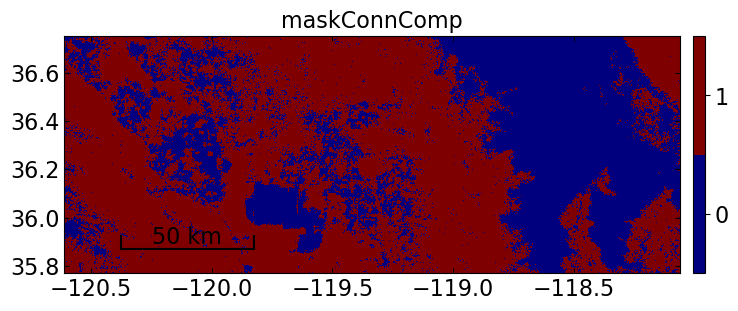

In [15]:
!generate_mask.py  inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update
view.main(['maskConnComp.h5'])

In [16]:
#!view.py 

## reference_point


The interferometric phase is relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore we need to reference all interferograms to a common reference pixel.
The step "reference_point" selects a common reference pixel for the stack of interferograms. The default approach of mintpy is to choose a pixel with highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.    

In [17]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep reference_point'
process = subprocess.run(command, shell=True)
#!smallbaselineApp.py Central_Valley.cfg --dostep reference_point

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2023-10-31 20:28:24.207866--
Current directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Central_Valley
Go to work directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
read custom template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/Central_Valley.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/sm

Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the ifgramStack.h5 file. To see the attributes of the file run info.py:

In [18]:
!info.py inputs/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                                         36.6333333805
  REF_LON                                         -119.26916720349999
  REF_X                                           1609
  REF_Y                                           141


In this case, I set the reference point latitude and longitude to be in a location, and MintPy calculated the X and Y locations.

## 2.4. Inverting of the Small Baseline network

In the next step we invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date. By default mintpy selects the first acquisition. The estimated time-series is converted to distance change from radar to target and is provided in meters. 

In [19]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep invert_network'
process = subprocess.run(command, shell=True)
#!smallbaselineApp.py Central_Valley.cfg  --dostep invert_network

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2023-10-31 20:28:26.952804--
Current directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Central_Valley
Go to work directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
read custom template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/Central_Valley.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/smallbaselineApp.cfg


******************** step - invert_netwo

The timeseries file contains three datasets:
- the "time-series" which is the interferometric range change for each acquisition relative to the reference acquisition,
- the "date" dataset which contains the acquisition date for each acquisition,
- the "bperp" dataset which contains the timeseries of the perpendicular baseline.  

## 2.5. Estimating the long-term velocity rate

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. 

In [20]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep velocity'
process = subprocess.run(command, shell=True)
#!smallbaselineApp.py Central_Valley.cfg  --dostep velocity

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2023-10-31 20:28:49.778311--
Current directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Central_Valley
Go to work directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
read custom template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/Central_Valley.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/timeseries.h5 -t /home/jovyan/CentralV

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/velocity.h5 in float32 format
file size in y/x: (1177, 3061)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 3061, 1177)
subset coverage in y/x: (0, 0, 3061, 1177)
data   coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
subset coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [10.00, 3.08]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-33.016975, 5.941] cm/year
display range: [-30.0, 30.0] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot sc

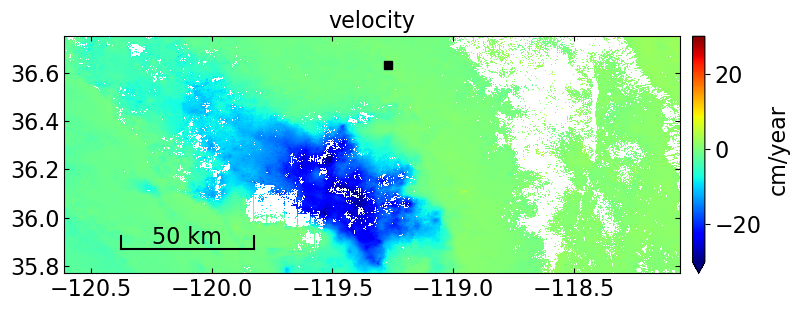

In [21]:
scp_args = 'velocity.h5 velocity -v -30 30'
view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
    The line of sight (LOS) for this descending Sentinel-1 track is up and east from ground to radar.
</div>

Obvious features in the estimated velocity map:

1) We use a color scale for this velocity with a range of +/-30 cm/year due to the rapid subsidence velocity in this area. 

2) The negative LOS feature near the city of Corcoran (center left of map) is rapid subsidence due to groundwater extraction in the central part of the San Joaquin Valley, moving down and away from the radar satellite.

3) The block box at 36.63N, 119.26W is the reference pixel for this map, in a more stable part of the Central Valley. 

4) Most of the map is a green color as it is close to zero displacement with the large color scale.

# 3. Error analysis (what is signal, what is noise!)


Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in mintpy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 3.1 Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.

### 3.1.1 Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion. 

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is coherence file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/avgSpatialCoh.h5 in float32 format
file size in y/x: (1177, 3061)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 3061, 1177)
subset coverage in y/x: (0, 0, 3061, 1177)
data   coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
subset coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
------------------------------------------------------------------------
colormap: gray
figure title: avgSpatialCoh
figure size : [10.00, 3.08]
reading data ...
data    range: [0.0076670763, 0.99966854] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
showing ...


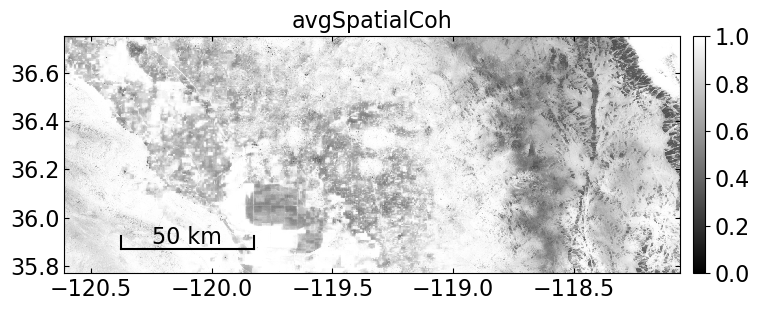

In [22]:
view.main(['avgSpatialCoh.h5'])

### 3.1.2 Temporal coherence

In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms. 

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is temporalCoherence file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/temporalCoherence.h5 in float32 format
file size in y/x: (1177, 3061)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 3061, 1177)
subset coverage in y/x: (0, 0, 3061, 1177)
data   coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
subset coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
figure size : [10.00, 3.08]
reading data ...
data    range: [0.0, 1.0] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
showing ...


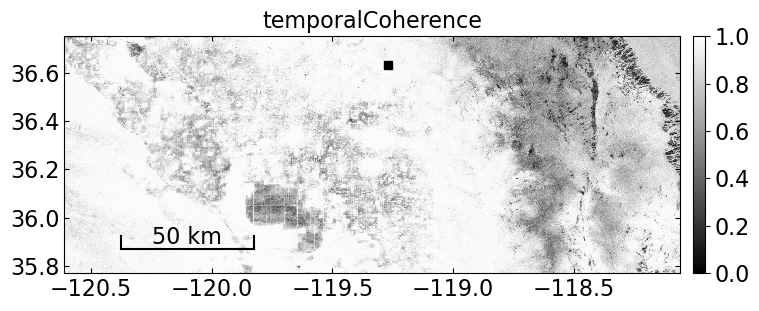

In [23]:
view.main(['temporalCoherence.h5'])

With both the spatial coherence and temporal coherence, we can see that the InSAR in the area of the Sierra Nevada (east of about 119W has unstable phase, and the InSAR measurements there will be low quality. There is also an area of low coherence in the low-elevation Tulare Lake bed near 119.6W, 36.0N, where the land changes a lot during the year. A much larger area flooded in the spring of 2023 when heavy rains caused high river flows that drained into the lake.

The velocity maps have a mask based on the temporal coherence so those low coherence areas are white.

## 3.2. Velocity error analysis

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset. 

**Mintpy supports additional corrections in its processing not included in this demo:**
- Unwrapping error correction
- Tropospheric delay correction
- deramping
- Topographic residual correction
- Residual RMS for noise evaluation
- Changing the reference date

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/velocity.h5 in float32 format
file size in y/x: (1177, 3061)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 3061, 1177)
subset coverage in y/x: (0, 0, 3061, 1177)
data   coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
subset coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
------------------------------------------------------------------------
colormap: jet
figure title: velocityStd
figure size : [10.00, 3.08]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [0.0, 2.4815676] cm/year
display range: [0.0, 1.5] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot

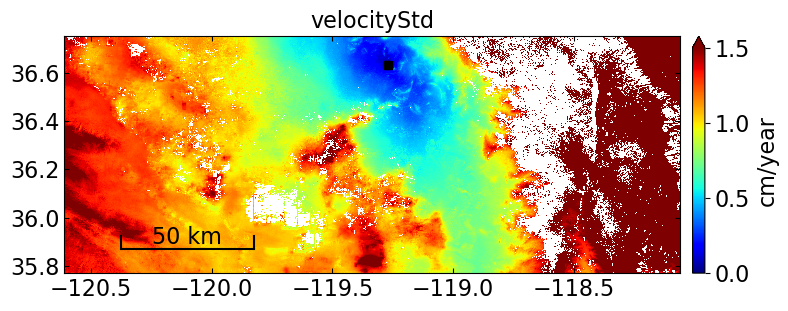

In [24]:
scp_args = 'velocity.h5 velocityStd -v 0 1.5'
view.main(scp_args.split())

Note that the plot above is the velocity error, not the velocity. The errors generally increase with distance from the reference point and also increase for points with elevations different from the reference point because of topographically correlated water vapor variations that are especially strong in this area. Variations of the ground subsidence away from a linear trend in time also cause an increase in the standard deviation of the velocity, so the strong seasonal variation in subsidence causes larger standard deviations in the subsidence bowl.

# 4. Plotting a Subsidence Transect 

In the next cell, we take a profile or transect through the subsidence signal.

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/velocity.h5 in float32 format
file size in y/x: (1177, 3061)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 3061, 1177)
subset coverage in y/x: (0, 0, 3061, 1177)
data   coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
subset coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [10.00, 3.08]
read mask from file: maskTempCoh.h5
data    range: [-33.016975, 5.941] cm/year
display range: [-33.016975, 5.941] cm/year
figure size : [10.00, 3.08]
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plo

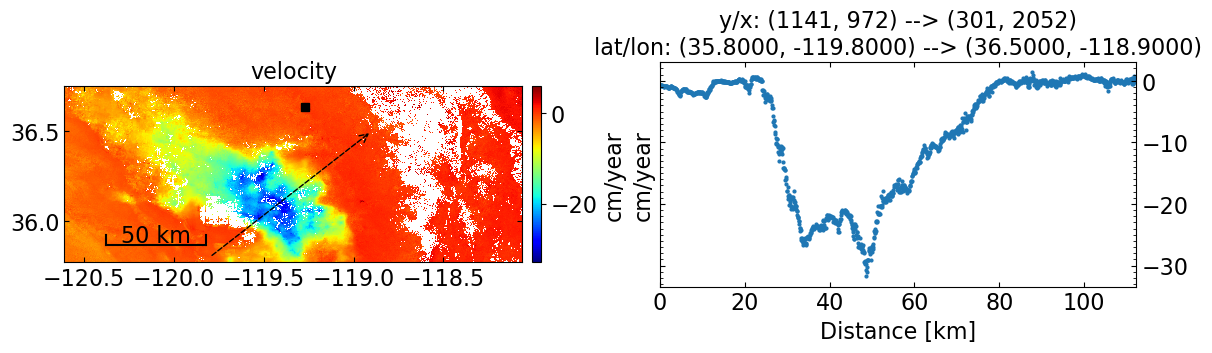

In [25]:
scp_args = 'velocity.h5 --start-lalo 35.8 -119.8 --end-lalo 36.5 -118.9 '
plot_transection.main(scp_args.split())



On this transect, the subsidence has an average velocity over the year 2018 that reaches more than 30 cm/year in the descending track 144 radar LOS direction. By analyzing the velocity on the ascending track and combining the two LOS directions, then we could find out that the displacements are almost all vertical due to extraction of groundwater from aquifers beneath the valley. 

If we assume the displacement is purely vertical, we can estimate the vertical component of displacement by dividing the LOS rate by the cosine of the incidence angle, or about 40 degrees for Sentinel-1. This means that the 30 cm/year LOS velocity is close to 39 cm/year vertical velocity.

## 5. Visualization

All HDF5 files can be plotted using view.py and/or tsview.py.

view.py: 2D plot(s) for:
the stack of interferogram, coherence,
velocity, temporal coherence, etc
DEM, products overlaid on DEM and many more
tsview.py: 1D time series plot
plot_transection.py: plot 1D profile along a line of a 2D matrix
plot_coherence_matrix.py: plot coherence matrix for one pixel
save_kmz.py: Google Earth points/raster for 2D displacement
save_kmz_timeseries.py: Google Earth points for 3D displacement time-series

The `smallbaselineApp.py` script also has a step to run the `save_kmz.py` and generate a KMZ for viewing in Google Earth:

In [26]:
!smallbaselineApp.py smallbaselineApp.cfg --dostep google_earth

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2023-10-31 20:29:22.817466--
Current directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy
read default template file: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/smallbaselineApp.cfg


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded velocity file: ...

save_kmz.py /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/velocity.h5 -o /home/jovyan/CentralValley/work/CentralValleyA144/MintPy/velocity.kmz
['./pic/velocity.kmz'] exists and is newer than ['/home/jovyan/CentralValley/work/CentralValleyA144/MintPy/velocity.h5'] --> skip.
Go back to directory: /home/jovyan/CentralValley/work/CentralValleyA144/MintPy

###############

# Reference material

- Original MintPy Notebook withe detailed description by Yunjun and Fattahi at: https://nbviewer.jupyter.org/github/insarlab/MintPy-tutorial/blob/master/smallbaselineApp_aria.ipynb

- Mintpy reference: *Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: unwrapping error correction and noise reduction, preprint doi:[10.31223/osf.io/9sz6m](https://eartharxiv.org/9sz6m/).*

- MintPy published reference: *Yunjun, Z., H. Fattahi, and F. Amelung (2019), Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction, Computers & Geosciences, 133, 104331, doi:10.1016/j.cageo.2019.104331.* 


- University of Miami online time-series viewer: https://insarmaps.miami.edu/

- Mintpy Github repository: https://github.com/insarlab/MintPy

- ARIA-tools Github Repository: https://github.com/aria-tools/ARIA-tools